# Standard CSP pipelines

This notebook implements multiple standard CSP pipelines and tests their performance on the data from the database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211).
The knowledge and utilities obtained from the experimental notebooks four to five are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
- Same subject, same session
   - Same subject, same session: LDA classifier 
   - Same subject, same session: SVM classifier 
   - Same subject, same session: RF classifier 
- Same subject, new session
   - Same subject, new session: LDA classifier
   - Same subject, new session: SVM classifier
   - Same subject, new session: RF classifier
- New subject
   - New subject: LDA classifier
   - New subject: SVM classifier
   - New subject: RF classifier

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [ ]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

<hr>

### Correct module access

The following code block will load in all required modules.

In [ ]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io
import copy

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [ ]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
We do this for three different traditional machine learning classifiers: linear discriminant analysis (LDA), support vector machines (SVM) and random forest (RF).
K-nearest neighbour (KNN) is not considered as it is too time-consuming in predictions and complex models such as a multilayer perceptron (MLP) are not considered either as they are an integral part of the deep learning models considered in later notebooks.

<hr>

### Same subject, same session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, 
                                y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                                |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------------|
| B           | 0.6693 +- 0.02981                        | 0.6146                             | 4 CSP components \| SVM RBF with C 0.1 and Gamma auto     |
| C           | 0.7262 +- 0.0298                         | 0.7448                             | 6 CSP components \| SVM RBF with C 100 and Gamma 0.001    |
| E           | 0.7356 +- 0.0159                         | 0.7016                             | 6 CSP components \| SVM sigmoid with C 100 and Gamma 0.01 |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 6]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [0.1, 100, 100]
best_found_svm_gamma = ["auto", 0.001, 0.01]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only half a second window taking into account that the online system will use sliding windows.
      - This window starts at 0.1 seconds after the visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies of 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> RF
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.6588 +- 0.0316                         | 0.6042                             | 4 CSP components \| RF max depth 10, max features 0.4, min sample split 10, 50 estimators    |
| C           | 0.7119 +- 0.0316                         | 0.7031                             | 6 CSP components \| RF max depth 3, max features 0.4, min sample split 5, 250 estimators     |
| E           | 0.7251 +- 0.0176                         | 0.7539                             | 10 CSP components \| RF max depth None, max features 0.2, min sample split 2, 250 estimators |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 10]
best_found_rf_depth = [10, 3, None]
best_found_rf_max_featues = [0.4, 0.4, 0.2]
best_found_rf_min_sample = [10, 5, 2]
best_found_rf_n_estimators = [50, 250, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy


<hr><hr>

## Same subject, new session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.



<hr>

### Same subject, new session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B           | 0.4500 +- 0.02576                        | 0.4677                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| C           | 0.8177 +- 0.01940                        | 0.3587                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| E           | 0.5525 +- 0.03678                        | 0.5518                             | CSP 10 components \| SVD LDA with 0.0001 tol |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### Same subject, new session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_cspsvm.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                             |
|-------------|------------------------------------------|------------------------------------|--------------------------------------------------------|
| B           | 0.4625 +- 0.0276                         | 0.4677                             | 10 CSP components \| rbf SVM with C 10 and gamma 0.01  |
| C           | 0.8338 +- 0.0213                         | 0.3754                             | 10 CSP components \| rbf SVM with C 1 and gamma auto   |
| E           | 0.5816 +- 0.0255                         | 0.3895                             | 10 CSP components \| rbf SVM with C 1 and gamma scale  |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_cspsvm.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [10, 1, 1]
best_found_svm_gamma = [0.01, "auto", "scale"]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### Same subject, new session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csprf.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                   |
|-------------|-----------------------------------------|-----------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.4489 +- 0.0351                        | 0.4406                            | 10 CSP components \| RF with max depth 3, 0.4 features, 10 min sample split, 500 estimators  |
| C           | 0.8198 +- 0.0198                        | 0.3462                            | 10 CSP components \| RF with max depth None, 0.2 features, 2 min sample split, 50 estimators |
| E           | 0.5770 +- 0.0290                        | 0.4911                            | 10 CSP components \| RF with max depth 10, 0.4 features, 10 min sample split, 250 estimators |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csprf.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_rf_depth = [3, None, 10]
best_found_rf_max_featues = [0.4, 0.2, 0.4]
best_found_rf_min_sample = [10, 2, 10]
best_found_rf_n_estimators = [500, 50, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr><hr>

## New subject

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

<hr>

### New subject: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = True # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                ###################### PREPARE DATA ######################
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 10,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                #grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_csplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
                del train_subject
                del train_subjects
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config** |
|-------------|------------------------------------------|------------------------------------|------------|
| B           | xxx                                      | xxx                                | xxx        |
| C           | xxx                                      | xxx                                | xxx        |
| E           | xxx                                      | xxx                                | xxx        |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_csplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.39610840861709523


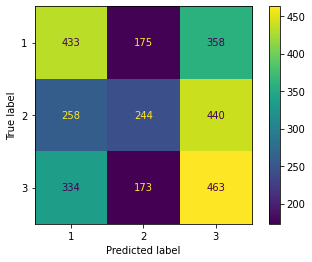

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


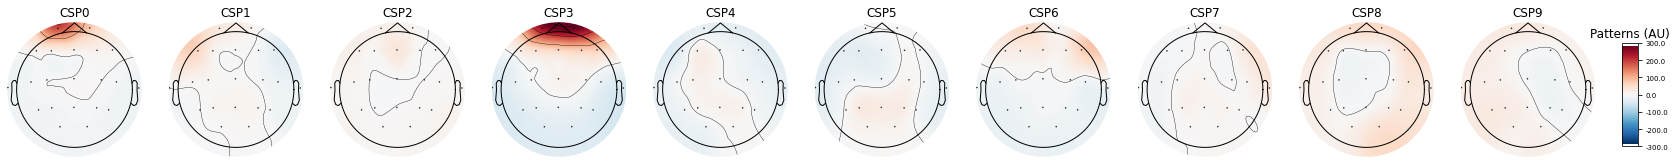




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################





KeyboardInterrupt: 

In [12]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raws = CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine test data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        del mne_raws
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del train_subjects
del train_subject
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound